# Giới thiệu về dữ liệu

Dữ liệu sử dụng ở đây là dữ liệu ghi nhận các vụ phạm tội do Chicago Police Department cung cấp. Những thông tin xung quanh dữ liệu và cách thức hình thành dữ liệu có thể tham khảo [ở đây](https://data.cityofchicago.org/Public-Safety/Crimes-2021/dwme-t96c).

---

In [2]:
import geopandas as gpd
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings

from datetime import date
from shapely.geometry import *
from shapely import speedups

speedups.enabled
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

---

# Quan sát và xử lý dữ liệu

#### Quan sát sơ lược dữ liệu

In [3]:
crime_df = pd.read_csv('crime_2021.csv')
crime_df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12260346,JE102126,01/03/2021 01:23:00 PM,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,6.0,68,08B,1174496.0,1858251.0,2021,01/16/2021 03:49:23 PM,41.766435,-87.635964,"(41.766435144, -87.635963997)"
1,12263464,JE105797,01/03/2021 06:59:00 AM,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,17.0,44,06,1176011.0,1851718.0,2021,01/16/2021 03:49:23 PM,41.748474,-87.630607,"(41.748473982, -87.630606588)"
2,12259990,JE101773,01/03/2021 12:20:00 AM,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,29.0,25,08B,1138722.0,1900183.0,2021,01/16/2021 03:49:23 PM,41.882224,-87.766076,"(41.88222427, -87.766076162)"


In [4]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189916 entries, 0 to 189915
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    189916 non-null  int64  
 1   Case Number           189916 non-null  object 
 2   Date                  189916 non-null  object 
 3   Block                 189916 non-null  object 
 4   IUCR                  189916 non-null  object 
 5   Primary Type          189916 non-null  object 
 6   Description           189916 non-null  object 
 7   Location Description  189289 non-null  object 
 8   Arrest                189916 non-null  bool   
 9   Domestic              189916 non-null  bool   
 10  Beat                  189916 non-null  int64  
 11  District              189916 non-null  int64  
 12  Ward                  189906 non-null  float64
 13  Community Area        189916 non-null  int64  
 14  FBI Code              189916 non-null  object 
 15  

In [5]:
crime_df.isna().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     627
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                      10
Community Area             0
FBI Code                   0
X Coordinate            1363
Y Coordinate            1363
Year                       0
Updated On                 0
Latitude                1363
Longitude               1363
Location                1363
dtype: int64

#### Thông tin chi tiết mô tả các trường của dữ liệu

Dưới đây là phần mô tả được cung cấp trong đường dẫn:
- **ID**: Unique identifier for the record.
- **Case Number**: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
- **Date**: Date when the incident occurred. This is sometimes a best estimate.
- **Block**: The partially redacted address where the incident occurred, placing it on the same block as the actual address.
- **IUCR**: The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. 
- **Primary Type**: The primary description of the IUCR code.
- **Description**: The secondary description of the IUCR code, a subcategory of the primary description.
- **Local Description**: Description of the location where the incident occurred.
- **Arrest**: Indicates whether an arrest was made.
- **Domestic**: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
- **Beat**: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts.
- **District**: Indicates the police district where the incident occurred.
- **Ward**: The ward (City Council district) where the incident occurred.
- **Community Area**: Indicates the community area where the incident occurred. Chicago has 77 community areas.
- **FBI Code**: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). 
- **X Coordinate**: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Y Coordinate**: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Year**: Year the incident occurred.
- **Updated On**: Date and time the record was last updated.
- **Latitude**: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Longitude**: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- **Location**: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

Như vậy, mỗi một dòng đại diện cho một record ghi nhận một vụ phạm tội.

#### Xử lý dữ liệu, loại bỏ những dòng nào thiếu giá trị ở bất kỳ trường dữ liệu nào.

Như ở trên, chúng ta quan sát được rằng có một số cột dữ liệu bị thiếu giá trị. Tuy nhiên số lượng dòng có giá trị thiếu so với toàn bộ những dòng đủ giá trị còn lại là quá nhỏ (dưới 1500 dòng so với xấp xỉ 190000 dòng dữ liệu). Vì vậy ta có thể tạm thời loại bỏ nó đi mà không làm ảnh hưởng đến kết quả quan sát

In [6]:
crime_df.dropna(inplace = True)
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187989 entries, 0 to 189915
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    187989 non-null  int64  
 1   Case Number           187989 non-null  object 
 2   Date                  187989 non-null  object 
 3   Block                 187989 non-null  object 
 4   IUCR                  187989 non-null  object 
 5   Primary Type          187989 non-null  object 
 6   Description           187989 non-null  object 
 7   Location Description  187989 non-null  object 
 8   Arrest                187989 non-null  bool   
 9   Domestic              187989 non-null  bool   
 10  Beat                  187989 non-null  int64  
 11  District              187989 non-null  int64  
 12  Ward                  187989 non-null  float64
 13  Community Area        187989 non-null  int64  
 14  FBI Code              187989 non-null  object 
 15  

#### Tạo trường dữ liệu địa lý từ các trường Latitude, Longitude và tạo Geo Dataframe từ dữ liệu ban đầu.

In [7]:
crime_df['geometry'] = None
for row in crime_df.index:
    crime_df.at[row, 'geometry'] = Point((crime_df.at[row, 'Latitude'], crime_df.at[row, 'Longitude']))

In [8]:
geo_crime_df = gpd.GeoDataFrame(crime_df)
geo_crime_df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,geometry
0,12260346,JE102126,01/03/2021 01:23:00 PM,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,68,08B,1174496.0,1858251.0,2021,01/16/2021 03:49:23 PM,41.766435,-87.635964,"(41.766435144, -87.635963997)",POINT (41.76644 -87.63596)
1,12263464,JE105797,01/03/2021 06:59:00 AM,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,44,06,1176011.0,1851718.0,2021,01/16/2021 03:49:23 PM,41.748474,-87.630607,"(41.748473982, -87.630606588)",POINT (41.74847 -87.63061)
2,12259990,JE101773,01/03/2021 12:20:00 AM,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,25,08B,1138722.0,1900183.0,2021,01/16/2021 03:49:23 PM,41.882224,-87.766076,"(41.88222427, -87.766076162)",POINT (41.88222 -87.76608)


In [9]:
geo_crime_df.set_crs(epsg = 4326)
geo_crime_df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,geometry
0,12260346,JE102126,01/03/2021 01:23:00 PM,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,68,08B,1174496.0,1858251.0,2021,01/16/2021 03:49:23 PM,41.766435,-87.635964,"(41.766435144, -87.635963997)",POINT (41.76644 -87.63596)
1,12263464,JE105797,01/03/2021 06:59:00 AM,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,44,06,1176011.0,1851718.0,2021,01/16/2021 03:49:23 PM,41.748474,-87.630607,"(41.748473982, -87.630606588)",POINT (41.74847 -87.63061)
2,12259990,JE101773,01/03/2021 12:20:00 AM,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,25,08B,1138722.0,1900183.0,2021,01/16/2021 03:49:23 PM,41.882224,-87.766076,"(41.88222427, -87.766076162)",POINT (41.88222 -87.76608)


#### Biểu đồ cơ bản về hình dạng địa lý chứa các địa điểm trong dữ liệu.

<AxesSubplot:>

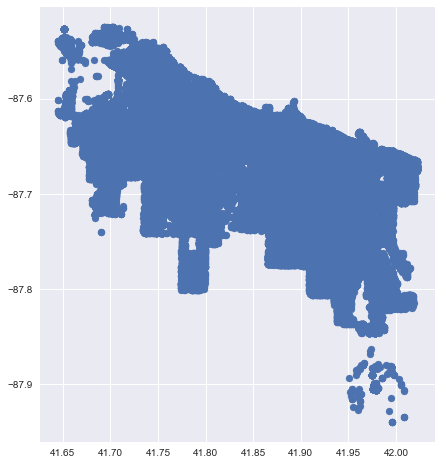

In [10]:
geo_crime_df.plot(figsize = (15, 8))

#### Biểu đồ cơ bản về hình dạng địa lý chứa phân vùng các Community Area.

Sử dụng file JSON chứa phân vùng các Community Area của thành phố Chicago để trực quan.

<AxesSubplot:>

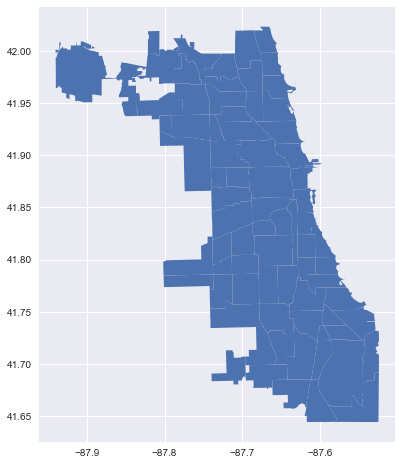

In [11]:
community_area = gpd.read_file('chicago-community-areas.geojson')
community_area.plot(figsize = (15, 8))

In [12]:
community_area.head(1)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."


#### Bản đồ nhiệt vùng địa lý xảy ra các sự kiện có mã FBI Code nhất định nào đó (có thể quan sát các vùng có mã FBI Code khác, nếu thay đổi mã).

Sử dụng mã FBI Code 20 làm truy vấn mẫu. Đối với các mã khác cách làm cũng tương tự.

In [13]:
import folium

In [14]:
heat_df = gpd.GeoDataFrame(geo_crime_df[geo_crime_df['FBI Code'] == '20'].groupby('Community Area')['geometry'].unique())
heat_df = heat_df.reset_index()

In [15]:
heat_df = heat_df.explode()
heat_point = []
for point in heat_df['geometry'].unique():
    heat_point.append((point.x, point.y))

In [16]:
first_location = (geo_crime_df.at[0, 'geometry'].x, geo_crime_df.at[0, 'geometry'].y) 
first_location

(41.766435144, -87.635963997)

In [17]:
crime_map = folium.Map(first_location, zoom_start = 12, tiles = 'OpenStreetMap')

# Create boundaries
chicago_boundaries = ('chicago-community-areas.geojson')

folium.GeoJson(chicago_boundaries, style_function = lambda feature: {
        'fillColor': '#ffffff',
        'color': 'black',
        'weight': 0.5}, smooth_factor = 0.01).add_to(crime_map)

# Create heat print on map
from folium.plugins import HeatMap
HeatMap(heat_point).add_to(crime_map)

# Create marker point of event 
for point in heat_point:
    folium.CircleMarker(point, radius = 1.5, weight = 0,  fill_color = '#cc0000').add_to(crime_map)

folium.LayerControl().add_to(crime_map)
crime_map

In [18]:
crime_map.save('crime_map.html')

---

# EDA và một số xử lý thêm cho dữ liệu

#### Chuyển trường dữ liệu Date sang định dạng datetime và tạo trường dữ liệu Explicit Date để dễ phân tích sau này.

In [19]:
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
crime_df['Explicit_Date'] = crime_df['Date'].dt.date

#### Chuyển định dạng dữ liệu của trường FBI Code.

In [20]:
crime_df = crime_df.astype({'FBI Code' : 'string'})
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187989 entries, 0 to 189915
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    187989 non-null  int64         
 1   Case Number           187989 non-null  object        
 2   Date                  187989 non-null  datetime64[ns]
 3   Block                 187989 non-null  object        
 4   IUCR                  187989 non-null  object        
 5   Primary Type          187989 non-null  object        
 6   Description           187989 non-null  object        
 7   Location Description  187989 non-null  object        
 8   Arrest                187989 non-null  bool          
 9   Domestic              187989 non-null  bool          
 10  Beat                  187989 non-null  int64         
 11  District              187989 non-null  int64         
 12  Ward                  187989 non-null  float64       
 13 

#### Danh sách các loại hình phạm tội phổ biến 


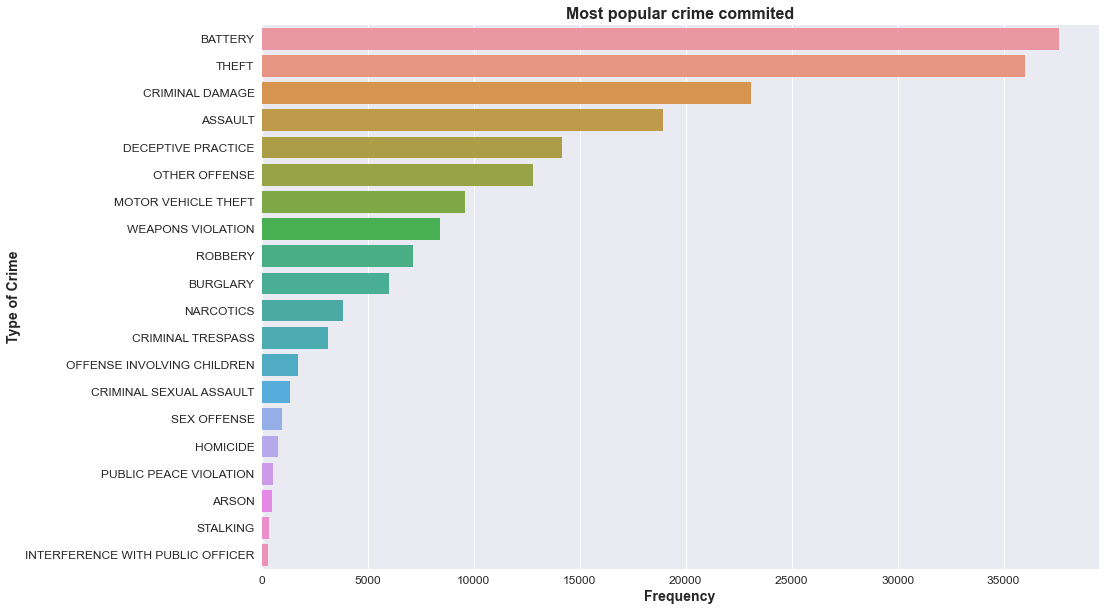

In [21]:
crime_type = crime_df['Primary Type'].value_counts()[:20]

plt.figure(figsize = (15, 10))
plt.xlabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.ylabel('Type of Crime', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Most popular crime commited', fontsize = 16, fontweight = 'bold')
sns.barplot(x = crime_type.values, y = crime_type.index)
plt.show()

#### Khung giờ nguy hiểm (thường xảy ra phạm tội nhất) trong ngày

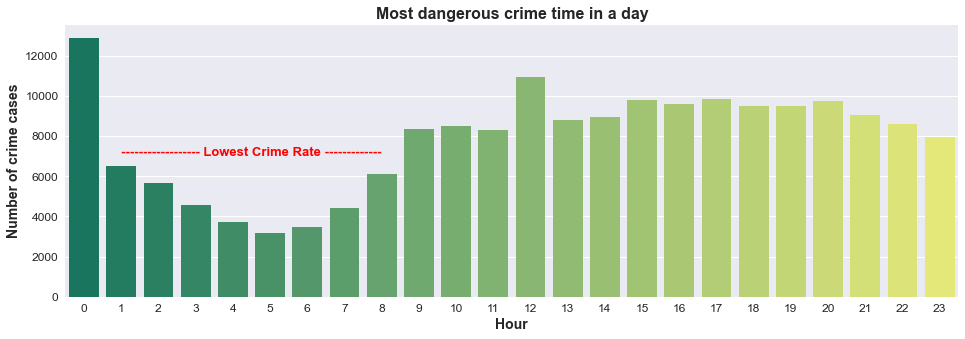

In [22]:
crime_df['Explicit_Hour'] = crime_df['Date'].dt.hour

plt.figure(figsize = (16, 5))
plt.title('Most dangerous crime time in a day', fontsize = 16, fontweight = 'bold')
sns.countplot(x = crime_df['Explicit_Hour'], data = crime_df, palette = 'summer')
plt.text(1, 7000, '------------------ Lowest Crime Rate -------------', fontdict = {'fontsize': 13, 'color': "red"}, weight = 'bold')
plt.xlabel('Hour', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of crime cases', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


Khung giờ dường như an toàn nhất là khoảng từ 1h đến 8h sáng. Ngoài ra, các khung giờ còn lại số lượng các vụ phạm tội xảy ra tương đối nhiều và thường xuyên hơn. Cá biệt, trong khung giờ nửa đêm, số vụ tội phạm gia tăng đột biến và chiếm số lượng lớn nhất

#### Khoảng thời gian nguy hiểm trong năm 

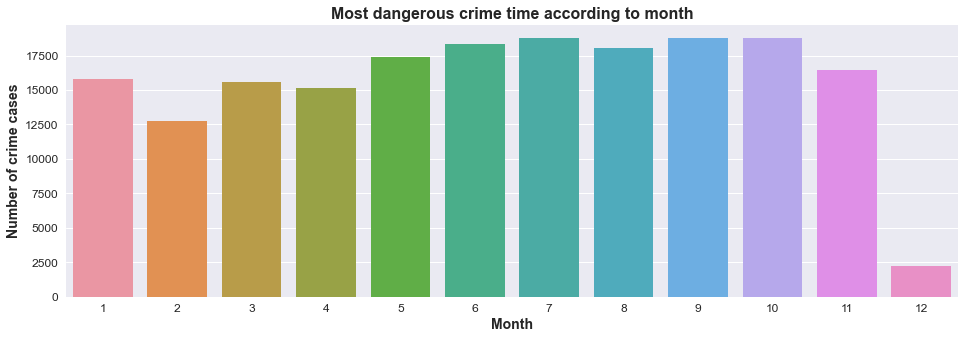

In [23]:
crime_df['Explicit_Month'] = crime_df['Date'].dt.month

plt.figure(figsize = (16, 5))
plt.title('Most dangerous crime time according to month', fontsize = 16, fontweight = 'bold')
sns.countplot(x = crime_df['Explicit_Month'], data = crime_df)
plt.xlabel('Month', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of crime cases', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


Tỷ lệ tội phạm có xu hướng gia tăng từ tháng 5 cho đến tháng 10

#### Số lượng các vụ phạm tội (đã bắt giữ được) theo ngày.

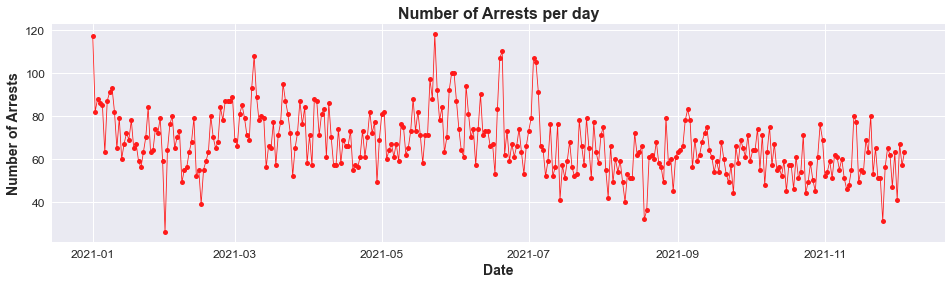

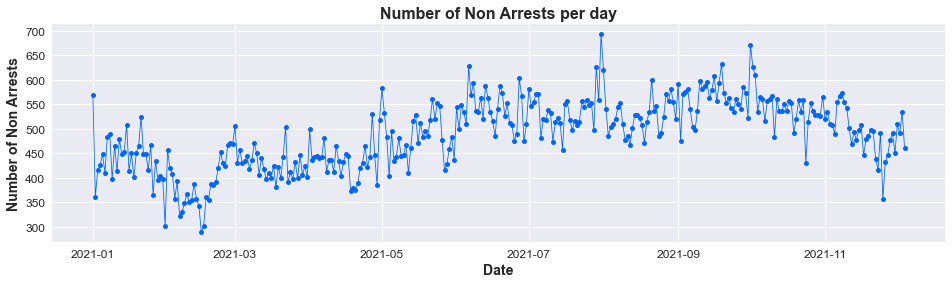

In [24]:
num_arrests = crime_df.groupby('Explicit_Date')['Arrest'].value_counts()
num_arrests_each_day = pd.Series(index = crime_df['Explicit_Date'].value_counts().index, dtype = 'float64')
for date in num_arrests_each_day.index:
    num_arrests_each_day[date] = num_arrests[date][True]
num_arrests_each_day = num_arrests_each_day.sort_index()

plt.figure(figsize = (16, 4))
plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of Arrests', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Number of Arrests per day', fontsize = 16, fontweight = 'bold')
plt.plot(num_arrests_each_day, linewidth = 0.8, color = '#ff1a1a', marker = 'o', markersize = 5)
plt.show()


for date in num_arrests_each_day.index:
    num_arrests_each_day[date] = num_arrests[date][False]
num_arrests_each_day = num_arrests_each_day.sort_index()

plt.figure(figsize = (16, 4))
plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of Non Arrests', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Number of Non Arrests per day', fontsize = 16, fontweight = 'bold')
plt.plot(num_arrests_each_day, linewidth = 0.8, color = '#0066ff', marker = 'o', markersize = 5)
plt.show()

Sự biến động của các biểu đồ là rất lớn, và có thể cần nhiều phân tích kĩ hơn để làm rõ sự biến động này. Nhưng nhìn chung, tương quan về số lượng giữa số vụ đã bắt giữ và không bắt giữ với nhau là rất lớn

Chúng ta cũng có thể nhận thấy từ biểu đồ các vụ không bắt giữ được thì trong khoảng tháng 5 đến tháng 10 số lượng các vụ này cũng tăng lên cao (khá hợp lý so với kết luận về các vụ phạm tội xảy ra trong từng tháng ở trên)

#### Tỷ lệ các vụ phạm tội có liên quan với nhau trong khu vực (domestic-related) theo ngày.

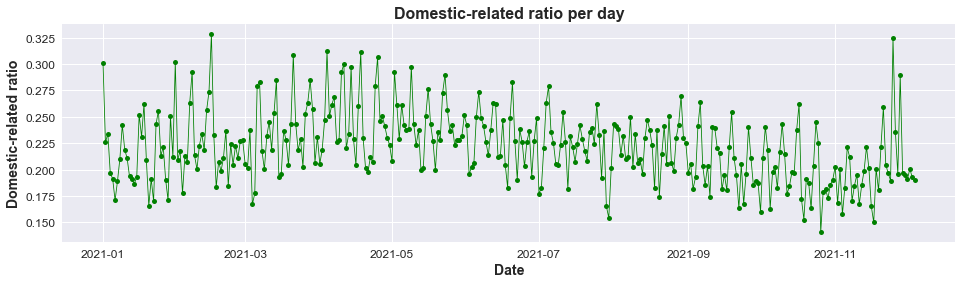

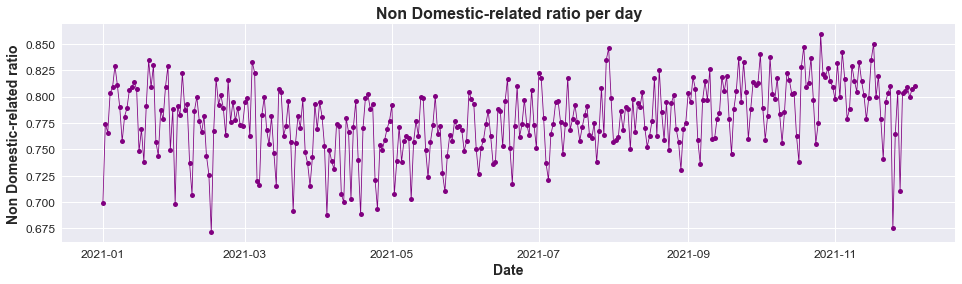

In [25]:
domestic_ratio = crime_df.groupby('Explicit_Date')['Domestic'].value_counts(normalize = True)
domestic_ratio_each_day = pd.Series(index = crime_df['Explicit_Date'].value_counts().index, dtype = 'float64')
for date in domestic_ratio_each_day.index:
    domestic_ratio_each_day[date] = domestic_ratio[date][True]
domestic_ratio_each_day = domestic_ratio_each_day.sort_index()

plt.figure(figsize = (16, 4))
plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
plt.ylabel('Domestic-related ratio', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Domestic-related ratio per day', fontsize = 16, fontweight = 'bold')
plt.plot(domestic_ratio_each_day, linewidth = 0.8, color = 'green', marker = 'o', markersize = 5)
plt.show()

for date in domestic_ratio_each_day.index:
    domestic_ratio_each_day[date] = domestic_ratio[date][False]
domestic_ratio_each_day = domestic_ratio_each_day.sort_index()

plt.figure(figsize = (16, 4))
plt.xlabel('Date', fontsize = 14, fontweight = 'bold')
plt.ylabel('Non Domestic-related ratio', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Non Domestic-related ratio per day', fontsize = 16, fontweight = 'bold')
plt.plot(domestic_ratio_each_day, linewidth = 0.8, color = 'purple', marker = 'o', markersize = 5)
plt.show()

Tỷ lệ các vụ phạm tội có liên quan với nhau trong khu vực thấp, nhưng có xu hướng tăng lên. Tỷ lệ các vụ phạm tội không liên quan với nhau trong khu vực tuy vẫn còn cao, nhưng có xu hướng giảm dần.

#### Lập bảng danh sách các District nào có số lượng vụ phạm tội nhiều nhất (ít nhất) theo ngày.

Cột Safe Districts để chỉ những District nào có số lượng vụ phạm tội ít nhất và Dangerous Districts là ngược lại. Với cách làm tương tự ta cũng có thể tìm ra đối với Beat, Ward hay Community Area.

In [26]:
district_df = pd.DataFrame(index = crime_df['Explicit_Date'].value_counts().index, columns = ['Safe Districts', 'Dangerous Districts'])
district_df = district_df.sort_index()
min_max_district = crime_df.groupby('Explicit_Date')['District'].value_counts()
for date in district_df.index:
    for district in district_df.columns:
        if district == 'Safe Districts':
            district_list = []
            for sub_district in min_max_district.loc[date].index:
                if min_max_district.loc[date][sub_district] == min_max_district.loc[date].min():
                    district_list.append(sub_district)
            district_df.at[date, district] = district_list
        else:
            district_list = []
            for sub_district in min_max_district.loc[date].index:
                if min_max_district.loc[date][sub_district] == min_max_district.loc[date].max():
                    district_list.append(sub_district)
            district_df.at[date, district] = district_list
        
                

In [27]:
district_df

,Safe Districts,Dangerous Districts
2021-01-01,[14],[7]
2021-01-02,[17],[4]
2021-01-03,"[20, 22]",[6]
2021-01-04,[1],[6]
2021-01-05,[20],[6]
...,...,...
2021-11-30,[20],[6]
2021-12-01,[20],[11]
2021-12-02,[20],[8]
2021-12-03,[20],"[6, 8]"


Với dataframe này, ở mỗi ngày chúng ta sẽ biết được District nào có số lượng vụ phạm tội xảy ra nhiều nhất, ít nhất. Hơn nữa, bằng cách thống kê theo ngày chúng ta cũng có thể biết được tần suất District nào nguy hiểm nhất hay an toàn nhất.

#### Địa điểm phạm tội nhiều nhất trong tháng (xét 5 địa điểm có vụ phạm tội nhiều nhất trong mỗi tháng)

In [28]:
location_df = copy.deepcopy(crime_df[['Explicit_Date', 'Location Description']])
location_df['Month'] = None
for row in location_df.index:
    location_df.at[row, 'Month'] = location_df.at[row, 'Explicit_Date'].month
location_by_month = location_df.groupby('Month')['Location Description'].value_counts()
for month in location_df['Month'].unique():
    print('Month {0}:'.format(month), list(location_by_month.loc[month].index[:5]))

Month 1: ['APARTMENT', 'STREET', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 2: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 4: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 3: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 5: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 6: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 7: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 8: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 9: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']
Month 10: ['STREET', 'APARTMENT', 'RESIDENCE', 'SIDEWALK', 'PARKING LOT / GARAGE (NON RESIDENTIAL)']

Điểm đặc biệt là địa điểm phạm tội phổ biến nhất trong 10 tháng đầu năm là như nhau. Khác biệt chỉ có tháng 1, địa điểm phạm tội bị đảo thứ tự so với các tháng còn lại. Kết quả này còn có thể bị ảnh hưởng bởi số vụ phạm tội được ghi nhận mỗi tháng, tức là nếu giữa các tháng số vụ phạm tội chệnh lệch rất nhiều thì không thể kết luận các địa điểm này là phổ biến. 

Ngoài ra, ở 2 tháng cuối năm thì chúng ta biết thêm được một địa điểm thường xuyên xảy ra vụ phạm tội mới là tại cửa hàng bán lẻ. Đây cũng có thể là một chi tiết hữu ích khi phân tích về xu hướng phạm tội mới, tại sao lại nổi lên địa điểm này

In [29]:
location_df['Month'].value_counts().sort_index()

1     15824
2     12724
3     15582
4     15150
5     17370
6     18361
7     18754
8     18053
9     18774
10    18740
11    16432
12     2225
Name: Month, dtype: int64

Nhìn chung, tương quan số vụ phạm tội trong các tháng không chênh lệch nhau quá nhiều. Tuy nhiên có điểm đáng lưu ý ở đây là trong giai đoạn tháng 5 đến tháng 10, số vụ phạm tội luôn ghi nhận ở mức cao trong danh sách. Chúng ta lưu ý đến điều này khi phân tích và coi nó như một dẫn chứng trong những phân tích sâu hơn về tình hình phạm tội, đặc biệt trong thời điểm dịch Covid-19

Còn tháng 12 số vụ phạm tội ghi nhận là quá ít so với tổng thể (vì hiện tại mới đầu tháng, dữ liệu chưa được thu thập đầy đủ), nên kết quả tháng 12 thể hiện chỉ mang tính chất tham khảo.

Xem thêm về số ngày thu thập dữ liệu giữa các tháng có chênh lệch nhau nhiều không.

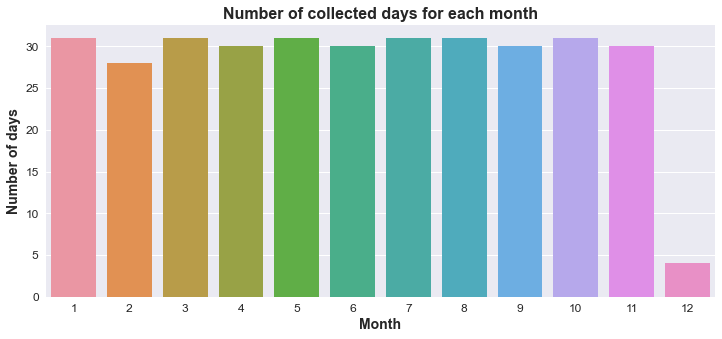

In [30]:
location_df['Day of Month'] = None
for row in location_df.index:
    location_df.at[row, 'Day of Month'] = location_df.at[row, 'Explicit_Date'].day
num_days_of_month = location_df.groupby('Month')['Day of Month'].nunique()
plt.figure(figsize = (12, 5))
plt.xlabel('Month', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of days', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Number of collected days for each month', fontsize = 16, fontweight = 'bold')
sns.barplot(x = num_days_of_month.index, y = num_days_of_month.values)
plt.show()

#### Loại tội phạm xảy ra nhiều nhất theo ngày mô tả bởi mã IUCR.

Khi truy vấn một ngày nhất định, thông tin về loại tội phạm xảy ra nhiều nhất trong ngày đó sẽ được thông báo dưới dạng tuple gồm có 3 thành phần: IUCR - Primary Type (Primary Description) - Description (Secondary Description)

In [31]:
iucr = crime_df.groupby(['Explicit_Date', 'IUCR', 'Primary Type'])['Description'].value_counts().unstack(level = 0).idxmax()
iucr[dt.date(2021, 5, 3)]

('0486', 'BATTERY', 'DOMESTIC BATTERY SIMPLE')

#### Làm rõ hơn về ý nghĩa của Beat, District và Community Area

Theo mô tả của dữ liệu thì có thể thấy, Beat là đơn vị hành chính nhỏ nhất, và District thì chứa nhiều Beat khác nhau, và Community Area thì cũng chứa nhiều Beat. Vấn đề cần làm rõ ở đây là tính tỷ lệ chồng chéo, tức là tỷ lệ Beat thuộc nhiều District hoặc Beat thuộc nhiều Community Area là bao nhiêu?

Tỷ lệ Beat thuộc nhiều District:

In [32]:
multi_district = crime_df.groupby('Beat')['District'].value_counts()
multi_district = multi_district.unstack(level = 1).dropna(thresh = 2)
multi_district_ratio = len(multi_district.index) / crime_df['Beat'].nunique()
multi_district_ratio

0.01824817518248175

Tỷ lệ Beat thuộc nhiều Community Area:

In [33]:
multi_comarea = crime_df.groupby('Beat')['Community Area'].value_counts()
multi_comarea = multi_comarea.unstack(level = 1).dropna(thresh = 2)
multi_comarea_ratio = len(multi_comarea.index) / crime_df['Beat'].nunique()
multi_comarea_ratio

0.5291970802919708

---

# Nhóm các sự kiện thường xuất hiện cùng nhau

**Ý tưởng**: Gom nhóm các sự kiện (có mã FBI Code tương ứng), theo ngày. Bởi vì sự kiện có khả năng lặp lại, ta thống kê số lần lặp lại của từng sự kiện trong mỗi ngày và coi đó là utility của sự kiện đó. Sau đó tạo transaction database để có thể áp dụng thuật toán khai thác dữ liệu. Ý tưởng này được tham khảo từ: https://data-mining.philippe-fournier-viger.com/introduction-high-utility-itemset-mining/

**Các bước thực hiện**:
- Ban đầu, xem như các mã FBI Code đều có trọng số như nhau (bằng 1). Như vậy thì tại mỗi ngày ghi nhận các sự kiện, số lần xuất hiện của sự kiện cũng chính là tổng trọng số của sự kiện đó trong ngày (tổng trọng số của mỗi sự kiện trong ngày là utility trong ngày của sự kiện đó). Sau đó, từ tập các sự kiện trong ngày, tính được utility toàn bộ do tất cả các sự kiện trong ngày đó tạo ra bằng cách tính tổng tất cả các utility sự kiện.
- Như vậy, sau quá trình tính mỗi ngày như vậy, thu được transaction database mô tả cho từng ngày. Mục tiêu ở đây là đi tìm tập các sự kiện tạo được nhiều utility nhất có thể trong toàn bộ transaction database. Tập các sự kiện này cũng biểu thị các sự kiện này luôn đi kèm với nhau nhiều nhất và có nhiều tác động nhất trong database.
- Quá trình khai thác những tập dữ liệu này sử dụng thuật toán từ phần mềm SPMF (open-source). Chi tiết có thể xem [ở đây](http://www.philippe-fournier-viger.com/spmf/)

**Các thuật toán sử dụng (High-Utility Itemsets Mining Algorithm)**:
- [CHUI-Miner](https://www.philippe-fournier-viger.com/spmf/CHUI-Miner.php): dùng để tìm các tập đóng (closed itemsets) có utility cao.
- [CHUI-Miner(Max)](https://www.philippe-fournier-viger.com/spmf/CHUI-MinerMax.php): dùng để tìm các tập tối đại (maximal) có utility cao.

**Tham số khi chạy thuật toán**: có thể đặt Minium utility bằng utility của record có giá trị nhỏ nhất (hoặc lớn nhất) trong database.

In [34]:
code_by_day = crime_df.groupby('Explicit_Date')['FBI Code'].value_counts()
df = code_by_day.unstack(level = 1)
transaction_df = pd.DataFrame(index = df.index, columns = ['FBI Code', 'Utility', 'FBI Code Utility Respectively'])
transaction_df.head()

,FBI Code,Utility,FBI Code Utility Respectively
Explicit_Date,,,
2021-01-01,NaN,NaN,NaN
2021-01-02,NaN,NaN,NaN
2021-01-03,NaN,NaN,NaN
2021-01-04,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN


In [35]:
df.fillna(0, inplace = True)
df

FBI Code,01A,01B,02,03,04A,04B,05,06,07,08A,...,14,15,16,17,18,19,20,22,24,26
Explicit_Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,2.0,0.0,18.0,11.0,20.0,25.0,21.0,72.0,22.0,27.0,...,93.0,63.0,2.0,16.0,12.0,0.0,4.0,0.0,6.0,65.0
2021-01-02,1.0,0.0,2.0,14.0,12.0,19.0,16.0,76.0,23.0,26.0,...,39.0,30.0,0.0,2.0,20.0,0.0,3.0,1.0,1.0,40.0
2021-01-03,2.0,0.0,3.0,20.0,17.0,15.0,15.0,66.0,30.0,18.0,...,72.0,31.0,0.0,2.0,24.0,0.0,2.0,0.0,4.0,32.0
2021-01-04,3.0,0.0,5.0,13.0,11.0,19.0,18.0,84.0,23.0,39.0,...,52.0,30.0,0.0,6.0,14.0,0.0,2.0,0.0,1.0,35.0
2021-01-05,1.0,0.0,1.0,22.0,10.0,10.0,21.0,90.0,29.0,40.0,...,62.0,27.0,0.0,3.0,21.0,0.0,1.0,0.0,8.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.0,0.0,2.0,26.0,17.0,21.0,24.0,126.0,35.0,46.0,...,38.0,23.0,0.0,4.0,13.0,0.0,1.0,0.0,5.0,31.0
2021-12-01,3.0,0.0,1.0,32.0,21.0,22.0,19.0,110.0,46.0,57.0,...,55.0,15.0,0.0,4.0,13.0,0.0,3.0,0.0,4.0,32.0
2021-12-02,2.0,0.0,10.0,31.0,27.0,19.0,26.0,89.0,34.0,61.0,...,61.0,23.0,0.0,8.0,14.0,0.0,2.0,0.0,2.0,40.0


#### Mã hóa các FBI Code thành số nguyên để có thể áp dụng thuật toán khai thác dữ liệu.

In [36]:
encode_dict = {}
i = 1
for column in df.columns:
    encode_dict[column] = i
    i += 1
encode_dict

{'01A': 1,
 '01B': 2,
 '02': 3,
 '03': 4,
 '04A': 5,
 '04B': 6,
 '05': 7,
 '06': 8,
 '07': 9,
 '08A': 10,
 '08B': 11,
 '09': 12,
 '10': 13,
 '11': 14,
 '12': 15,
 '13': 16,
 '14': 17,
 '15': 18,
 '16': 19,
 '17': 20,
 '18': 21,
 '19': 22,
 '20': 23,
 '22': 24,
 '24': 25,
 '26': 26}

#### Xử lý, tạo transaction database

In [37]:
for row in df.index:
    code_list = []
    code_utility = []
    for column in df.columns:
        if df.at[row, column] != 0:
            code_list.append(encode_dict[column])
            code_utility.append(int(df.at[row, column]))
    transaction_df.at[row, 'FBI Code'] = code_list
    transaction_df.at[row, 'FBI Code Utility Respectively'] = code_utility
    transaction_df.at[row, 'Utility'] = sum(code_utility)

In [38]:
pd.set_option('max_colwidth', 999)
transaction_df.head(3)

,FBI Code,Utility,FBI Code Utility Respectively
Explicit_Date,,,
2021-01-01,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26]",687,"[2, 18, 11, 20, 25, 21, 72, 22, 27, 135, 1, 71, 1, 93, 63, 2, 16, 12, 4, 6, 65]"
2021-01-02,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 20, 21, 23, 24, 25, 26]",443,"[1, 2, 14, 12, 19, 16, 76, 23, 26, 65, 1, 52, 39, 30, 2, 20, 3, 1, 1, 40]"
2021-01-03,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 20, 21, 23, 25, 26]",504,"[2, 3, 20, 17, 15, 15, 66, 30, 18, 92, 1, 58, 72, 31, 2, 24, 2, 4, 32]"


#### Xử lý để xuất ra định dạng dữ liệu phù hợp với phần mềm khai thác dữ liệu SPMF

In [39]:
for row in transaction_df.index:
    string_1 = (str(transaction_df.at[row, 'FBI Code'])).replace('\n','').strip('[]').strip()
    string_1 = ' '.join(string_1.split())
    transaction_df.at[row, 'FBI Code'] = string_1.replace(',','')

In [40]:
for row in transaction_df.index:
    string = (str(transaction_df.at[row, 'FBI Code Utility Respectively'])).replace('\n','').strip('[]').strip()
    string = ' '.join(string.split())
    transaction_df.at[row, 'FBI Code Utility Respectively'] = string.replace(',', '')

In [41]:
transaction_df

,FBI Code,Utility,FBI Code Utility Respectively
Explicit_Date,,,
2021-01-01,1 3 4 5 6 7 8 9 10 11 13 14 16 17 18 19 20 21 23 25 26,687,2 18 11 20 25 21 72 22 27 135 1 71 1 93 63 2 16 12 4 6 65
2021-01-02,1 3 4 5 6 7 8 9 10 11 12 14 17 18 20 21 23 24 25 26,443,1 2 14 12 19 16 76 23 26 65 1 52 39 30 2 20 3 1 1 40
2021-01-03,1 3 4 5 6 7 8 9 10 11 12 14 17 18 20 21 23 25 26,504,2 3 20 17 15 15 66 30 18 92 1 58 72 31 2 24 2 4 32
2021-01-04,1 3 4 5 6 7 8 9 10 11 12 13 14 17 18 20 21 23 25 26,513,3 5 13 11 19 18 84 23 39 65 1 5 87 52 30 6 14 2 1 35
2021-01-05,1 3 4 5 6 7 8 9 10 11 12 13 14 17 18 20 21 23 25 26,533,1 1 22 10 10 21 90 29 40 69 1 1 87 62 27 3 21 1 8 29
...,...,...,...
2021-11-30,3 4 5 6 7 8 9 10 11 12 13 14 17 18 20 21 23 25 26,513,2 26 17 21 24 126 35 46 78 1 3 19 38 23 4 13 1 5 31
2021-12-01,1 3 4 5 6 7 8 9 10 11 12 13 14 17 18 20 21 23 25 26,550,3 1 32 21 22 19 110 46 57 79 2 6 26 55 15 4 13 3 4 32
2021-12-02,1 3 4 5 6 7 8 9 10 11 12 13 14 17 18 20 21 23 25 26,558,2 10 31 27 19 26 89 34 61 90 1 2 16 61 23 8 14 2 2 40


In [42]:
transaction_df['Utility'].min()

328

In [43]:
transaction_df['Utility'].max()

764

#### Xuất ra file đầu vào của phần mềm

In [44]:
transaction_df.to_csv('utility.txt', index = False, header = False, sep = ':')

#### Sau khi đã có file đầu vào, sử dụng phần mềm và đặt tham số thích hợp, để lưu lại được file đầu ra

In [45]:
file = open('utility_output.txt')
lines = file.readlines()

#### Xử lý file đầu ra để chuyển thành dataframe

In [46]:
import re

In [47]:
utility_dict = {'FBI Code': [], 'Utility': [], 'Support': []}
for line in lines:
    partition = line.strip().split('#')
    itemset = partition[0]
    support = re.findall(r'\d+', partition[1])[0]
    utility = re.findall(r'\d+', partition[2])[0]
    utility_dict['FBI Code'].append(itemset)
    utility_dict['Support'].append(int(support))
    utility_dict['Utility'].append(int(utility))

In [48]:
utility_df = pd.DataFrame(utility_dict)
utility_df.head()

,FBI Code,Utility,Support
0,22 1 23 20 3 4 5 6 7 8 9 10 11 14 17 18 21 26,925,2
1,15 12 23 25 20 4 5 6 7 8 9 10 11 14 17 18 21 26 13 1,995,2
2,15 12 23 25 20 4 5 6 7 8 9 10 11 14 17 18 21 26 3,986,2
3,16 25 20 4 5 6 7 8 9 10 11 14 17 18 21 26 24 13 1,856,2
4,16 25 20 4 5 6 7 8 9 10 11 14 17 18 21 26 13 12 23,931,2


Lấy tập các sự kiện tạo ra được nhiều utility nhất, và mã hóa ngược lại xem đó là những sự kiện nào.

In [49]:
max_utility = utility_df['Utility'].max()
most_frequent_event = utility_df[utility_df['Utility'] == max_utility]
most_frequent_event = list(most_frequent_event['FBI Code'].values)
event = most_frequent_event[0].strip().split(' ')

In [50]:
decode_event = []
for key, value in encode_dict.items():
    for item in event:
        if int(item) == value:
            decode_event.append(key)
decode_event

['02',
 '03',
 '04A',
 '04B',
 '05',
 '06',
 '07',
 '08A',
 '08B',
 '11',
 '14',
 '15',
 '18',
 '20',
 '22',
 '26']

---

# Lộ trình thường xuyên của một sự kiện

**Ý tưởng**: Trước tiên sẽ trích xuất từ dữ liệu ban đầu ra được những record theo một mã sự kiện (FBI Code) nào đó cần quan tâm. Tiến hành tương tự như cách tiếp cận khi xử lý với nhóm các sự kiện thường xuất hiện với nhau.

**Các bước thực hiện**: Tương tự như với cách làm đối với các nhóm sự kiện. Ở đây chúng ta có thể sử dụng thêm một ràng buộc đơn giản để thực hiện đó là giới hạn số lượng lộ trình tìm được, chỉ tìm kiếm tối đa khoảng 20 lộ trình phổ biến (tính bằng utility) nhất.

**Thuật toán sử dụng**: Có thể sử dụng các thuật toán tương tự với các thuật toán trên. Tuy nhiên vì ở đây chúng ta thêm ràng buộc nên sẽ sử dụng thuật toán [TKU](https://www.philippe-fournier-viger.com/spmf/TKU.php) để tìm kiếm ra được số lượng k lộ trình phổ biến nhất từ cơ sở dữ liệu.

**Tham số sử dụng**: số lượng lộ trình do người dùng quan tâm. Ví dụ, đặt k = 20

In [51]:
crime_df['FBI Code'].value_counts().head()

06     36022
08B    30220
14     23096
08A    15900
11     13354
Name: FBI Code, dtype: Int64

In [52]:
crime_df['District'].unique()

array([ 7,  6, 15,  3,  4, 12, 24, 10, 14, 22, 18,  5, 11,  9,  2, 25,  8,
       17, 20, 16, 19,  1, 31], dtype=int64)

In [53]:
crime_df['District'].value_counts()

6     12400
11    12165
8     11677
4     11330
25     9868
7      9754
12     9700
3      9651
18     8975
5      8777
2      8620
19     8508
9      8322
10     8317
1      8028
15     7301
16     7049
22     6331
14     6175
24     6096
17     5158
20     3774
31       13
Name: District, dtype: int64

#### Xử lý, lọc dữ liệu để tạo cơ sở dữ liệu của một sự kiện

In [54]:
frequent_event = crime_df[crime_df['FBI Code'] == '06']
district_by_day = frequent_event.groupby('Explicit_Date')['District'].value_counts()
district_df = district_by_day.unstack(level = 1)
district_df.head()

District,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,22,24,25,31
Explicit_Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,3.0,5.0,3.0,3.0,5.0,8.0,2.0,5.0,2.0,2.0,...,1.0,3.0,1.0,5.0,2.0,1.0,3.0,7.0,3.0,NaN
2021-01-02,5.0,4.0,1.0,2.0,4.0,3.0,5.0,4.0,2.0,2.0,...,1.0,3.0,2.0,10.0,7.0,4.0,3.0,2.0,4.0,NaN
2021-01-03,4.0,7.0,3.0,NaN,3.0,7.0,3.0,2.0,5.0,1.0,...,2.0,3.0,2.0,5.0,3.0,3.0,2.0,2.0,2.0,NaN
2021-01-04,3.0,1.0,5.0,6.0,4.0,4.0,3.0,5.0,7.0,2.0,...,3.0,2.0,4.0,4.0,4.0,2.0,NaN,5.0,5.0,NaN
2021-01-05,6.0,7.0,3.0,4.0,8.0,4.0,3.0,4.0,NaN,2.0,...,2.0,2.0,1.0,4.0,9.0,1.0,3.0,11.0,4.0,NaN


In [55]:
district_df.fillna(0, inplace = True)

In [56]:
transaction_df = pd.DataFrame(index = district_df.index, columns = ['District', 'Utility', 'District Utility Respectively'])
transaction_df.head()

,District,Utility,District Utility Respectively
Explicit_Date,,,
2021-01-01,NaN,NaN,NaN
2021-01-02,NaN,NaN,NaN
2021-01-03,NaN,NaN,NaN
2021-01-04,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN


In [57]:
for row in district_df.index:
    district_list = []
    district_utility = []
    for column in district_df.columns:
        if district_df.at[row, column] != 0:
            district_list.append(column)
            district_utility.append(int(district_df.at[row, column]))
    transaction_df.at[row, 'District'] = district_list
    transaction_df.at[row, 'District Utility Respectively'] = district_utility
    transaction_df.at[row, 'Utility'] = sum(district_utility)

In [58]:
transaction_df

,District,Utility,District Utility Respectively
Explicit_Date,,,
2021-01-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",72,"[3, 5, 3, 3, 5, 8, 2, 5, 2, 2, 4, 2, 2, 1, 3, 1, 5, 2, 1, 3, 7, 3]"
2021-01-02,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",76,"[5, 4, 1, 2, 4, 3, 5, 4, 2, 2, 1, 5, 2, 1, 3, 2, 10, 7, 4, 3, 2, 4]"
2021-01-03,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",66,"[4, 7, 3, 3, 7, 3, 2, 5, 1, 1, 5, 1, 2, 3, 2, 5, 3, 3, 2, 2, 2]"
2021-01-04,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 24, 25]",84,"[3, 1, 5, 6, 4, 4, 3, 5, 7, 2, 4, 5, 6, 3, 2, 4, 4, 4, 2, 5, 5]"
2021-01-05,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",90,"[6, 7, 3, 4, 8, 4, 3, 4, 2, 5, 5, 2, 2, 2, 1, 4, 9, 1, 3, 11, 4]"
...,...,...,...
2021-11-30,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",126,"[6, 9, 6, 3, 2, 6, 12, 4, 6, 1, 11, 9, 3, 3, 3, 12, 8, 3, 7, 8, 4]"
2021-12-01,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 24, 25]",110,"[6, 7, 7, 2, 3, 5, 4, 5, 2, 1, 5, 11, 4, 6, 5, 2, 9, 8, 3, 7, 8]"
2021-12-02,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25]",89,"[5, 2, 2, 4, 1, 2, 4, 9, 1, 4, 3, 11, 2, 1, 2, 6, 15, 4, 2, 1, 5, 3]"


In [59]:
for row in transaction_df.index:
    string_1 = (str(transaction_df.at[row, 'District'])).replace('\n','').strip('[]').strip()
    string_1 = ' '.join(string_1.split())
    transaction_df.at[row, 'District'] = string_1.replace(',','')

In [60]:
for row in transaction_df.index:
    string = (str(transaction_df.at[row, 'District Utility Respectively'])).replace('\n','').strip('[]').strip()
    string = ' '.join(string.split())
    transaction_df.at[row, 'District Utility Respectively'] = string.replace(',', '')

In [61]:
transaction_df['Utility'].max()

219

#### Xuất ra file dữ liệu sử dụng cho phần mềm

In [62]:
transaction_df.to_csv('district.txt', index = False, header = False, sep = ':')

#### Sau khi đã có file đầu ra từ phần mềm, tiến hành xử lý file để tạo dataframe

In [63]:
file = open('district_output.txt')
lines = file.readlines()

In [64]:
district_dict = {'District': [], 'Utility': []}
for line in lines:
    partition = line.strip().split('#')
    district_list = partition[0]
    utility = re.findall(r'\d+', partition[1])[0]
    district_dict['District'].append(district_list)
    district_dict['Utility'].append(int(utility))

In [65]:
route_df = pd.DataFrame(district_dict)
route_df.head()

,District,Utility
0,9 5 10 15 16 2 1 3 6 18 14 8 4 25 19 12,5769
1,9 10 7 15 16 6 2 1 3 18 8 4 25 19 14 12,5769
2,17 5 7 3 8 14 1 6 18 2 16 4 25 19 12,5887
3,5 7 3 16 2 14 1 6 18 8 4 25 19 12,5851
4,5 10 14 16 2 3 1 6 18 8 4 25 19 12,5786


Từ dataframe với mỗi dòng ghi nhận một lộ trình của sự kiện, chúng ta có thể biết được độ phổ biến (utility) của nó

---

# Tài liệu tham khảo

- Bộ dữ liệu cung cấp bởi Chicago Portal (cập nhật đến ngày 9/5/2021): tham khảo và download dưới nhiều định dạng [Chicago Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2021/dwme-t96c)
- Bộ công cụ xử lý dữ liệu địa lý GIS: tham khảo ở khóa học [Automating-GIS processes 2019](https://automating-gis-processes.github.io/site/)
- Công cụ xử lý, phân tích và trực quan dữ liệu [Pandas](https://pandas.pydata.org/)
- Phần mềm mã nguồn mở cung cấp các thuật toán phục vụ cho Khai thác dữ liệu [SPMF](http://www.philippe-fournier-viger.com/spmf/)
- Hướng dẫn sử dụng GUI của phần mềm SPMF: tham khảo [ở đây](http://www.philippe-fournier-viger.com/spmf/how_to_run_graphical_interface.php)
- Hướng dẫn sử dụng các thuật toán trên giao diện GUI của phần mềm SPMF: tham khảo [ở đây](https://www.philippe-fournier-viger.com/spmf/documentation.php)